In [2326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_leverage_resid2
warnings.filterwarnings("ignore")

# Dataset “Kuiper.xls” (переменные Price, Mileage, Cylinder, Liter, Cruise) #

In [2327]:
dataset = pd.read_csv("/kaggle/input/kuiper/kuiper.csv")
columns = ["Price", "Mileage", "Cylinder", "Liter", "Cruise"]
df = dataset[columns]

In [2328]:
df

,Price,Mileage,Cylinder,Liter,Cruise
0,17314.103129,8221,6,3.1,1
1,17542.036083,9135,6,3.1,1
2,16218.847862,13196,6,3.1,1
3,16336.913140,16342,6,3.1,1
4,16339.170324,19832,6,3.1,1
...,...,...,...,...,...
799,16507.070267,16229,6,3.0,1
800,16175.957604,19095,6,3.0,1
801,15731.132897,20484,6,3.0,1
802,15118.893228,25979,6,3.0,1


## Провести корреляционный анализ имеющихся данных. ##

<Axes: >

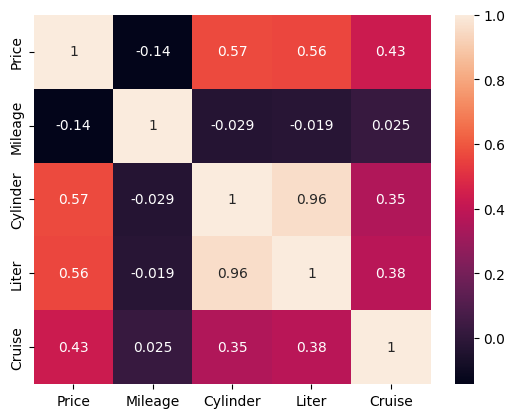

In [2329]:
sns.heatmap(df.corr(), annot = True)

Определяю функцию для определения доверительных интервалов

In [2330]:
def conf_interval(df, col1, col2):
    corr = stats.pearsonr(df[col1], df[col2])
    # Fisher transformation to get z
    z = np.arctanh(corr[0])
    # Standard error
    sigma = (1/((len(df.index)-3)**0.5))
    # Normal 95% interval probability density function 
    # for normal continuous random variable apply two-sided conditional formula
    cint = z + np.array([-1, 1]) * sigma * stats.norm.ppf((1+0.95)/2)
    # Hyperbolic tangent to get interval values for 95%
    res = np.tanh(cint)
    return res

Нулевая гипотеза - **незначимость** коэффициента

In [2331]:
for col1 in columns:
    for col2 in columns:
        print(f"Величины: {col1} и {col2}")
        print(f"Доверительные интервалы:{conf_interval(df, col1, col2)}")
        stat, p_value = stats.pearsonr(df[col1], df[col2])
        if (p_value < 0.05):
            print(f"pvalue: {p_value} < 0.05. (коэффициент корреляции значим)\n")
        else:
            print(f"pvalue: {p_value} > 0.05. (коэффициент корреляции не значим)\n")

Величины: Price и Price
Доверительные интервалы:[1. 1.]
pvalue: 0.0 < 0.05. (коэффициент корреляции значим)

Величины: Price и Mileage
Доверительные интервалы:[-0.21011376 -0.07464739]
pvalue: 4.684697954853461e-05 < 0.05. (коэффициент корреляции значим)

Величины: Price и Cylinder
Доверительные интервалы:[0.52042198 0.61406567]
pvalue: 3.454261230522203e-70 < 0.05. (коэффициент корреляции значим)

Величины: Price и Liter
Доверительные интервалы:[0.50863304 0.60397908]
pvalue: 4.9488121980182295e-67 < 0.05. (коэффициент корреляции значим)

Величины: Price и Cruise
Доверительные интервалы:[0.37281614 0.48552916]
pvalue: 1.1270325885417495e-37 < 0.05. (коэффициент корреляции значим)

Величины: Mileage и Price
Доверительные интервалы:[-0.21011376 -0.07464739]
pvalue: 4.684697954853333e-05 < 0.05. (коэффициент корреляции значим)

Величины: Mileage и Mileage
Доверительные интервалы:[1. 1.]
pvalue: 0.0 < 0.05. (коэффициент корреляции значим)

Величины: Mileage и Cylinder
Доверительные интерв

## Построить базовую модель линейной регрессии. ##

In [2332]:
X_cols = ["Mileage", "Cylinder", "Liter", "Cruise"]
y_col = "Price"

In [2333]:
def get_model(df, X_cols, y_col):
    X = df[X_cols]
    y = df[y_col]
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const)
    results = model.fit()
    return results

In [2334]:
results = get_model(df, X_cols, y_col)

## Вывести результаты анализа базовой модели. ##

In [2335]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     134.6
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           6.79e-88
Time:                        05:08:06   Log-Likelihood:                -8329.0
No. Observations:                 804   AIC:                         1.667e+04
Df Residuals:                     799   BIC:                         1.669e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2799.8569   1543.265      1.814      0.0

## Записать уравнение линейной регрессии. ##

In [2336]:
def print_equation(results):
    coefficients = results.params
    # Свободный член
    intercept = coefficients[0]
    # Коэффициенты при признаках
    slopes = coefficients[1:]
    
    equation = f"y = {intercept:.3f}"
    for i, slope in enumerate(slopes):
        equation += f" + ({slope:.3f}) * x{i+1}"

    print("Уравнение линейной регрессии:")
    print(equation)

In [2337]:
print_equation(results)

Уравнение линейной регрессии:
y = 2799.857 + (-0.164) * x1 + (3007.803) * x2 + (455.731) * x3 + (6076.049) * x4


## Проверить значимость каждого отдельного коэффициента с помощью  T-test. ##

In [2338]:
def t_test(results):
    t_values = results.tvalues
    p_values = results.pvalues

    for i, (t, p) in enumerate(zip(t_values, p_values)):
        term = "Intercept" if i == 0 else f"x{i}"
        significance = "коэффициент значим" if p < 0.05 else "коэффициент не значим"
        print(f"{term}: t_statistic = {t:.3f}, pvalue = {p:.3f} ({significance})")

In [2339]:
t_test(results)

Intercept: t_statistic = 1.814, pvalue = 0.070 (коэффициент не значим)
x1: t_statistic = -4.977, pvalue = 0.000 (коэффициент значим)
x2: t_statistic = 4.428, pvalue = 0.000 (коэффициент значим)
x3: t_statistic = 0.530, pvalue = 0.597 (коэффициент не значим)
x4: t_statistic = 8.981, pvalue = 0.000 (коэффициент значим)


## Проверить значимость построенного уравнения регрессии с помощью F-test. ##

Тестируемая гипотеза: H0: β1 = β2 = ... = βk = 0 (где β — коэффициенты модели), что означает, что модель не объясняет значимой доли вариации в зависимой переменной.

In [2340]:
def f_test(results):
    f_statistic = results.fvalue
    f_pvalue = results.f_pvalue
    print(f"F-statistic: {f_statistic:.4f}, p-value: {f_pvalue:.4f}")
    if (f_pvalue < 0.05):
        print("pvalue < 0.05. (модель значима)")
    else:
        print("pvalue < 0.05. (модель не значима)")

In [2341]:
f_test(results)

F-statistic: 134.6068, p-value: 0.0000
pvalue < 0.05. (модель значима)


## Построить график рассеяния и уравнения регрессии. ##

In [2342]:
def draw_regplots(df, X_cols, y_col):
    for col in X_cols:
        sns.regplot(x=col, y=y_col, data=df, scatter=True, line_kws={'color': 'red', 'linewidth': 2})
        plt.axhline(0, color='gray', linestyle='dashed')
        plt.grid()
        plt.show()

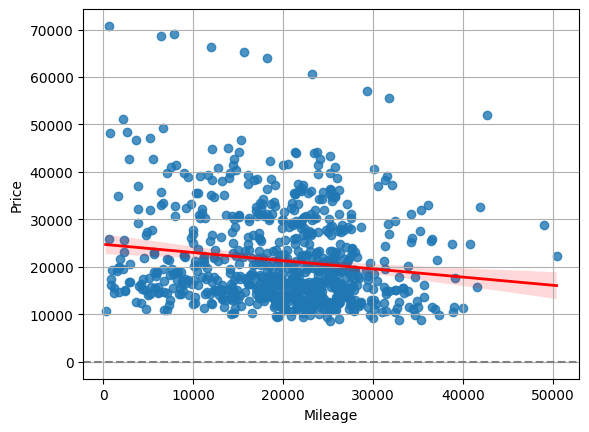

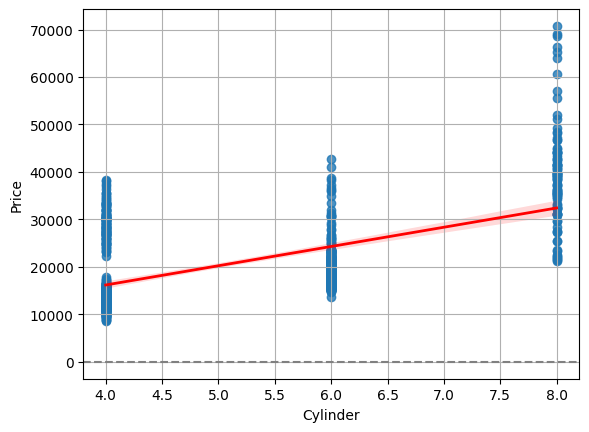

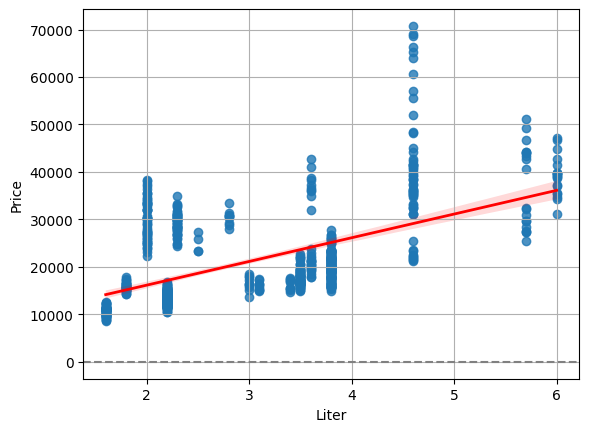

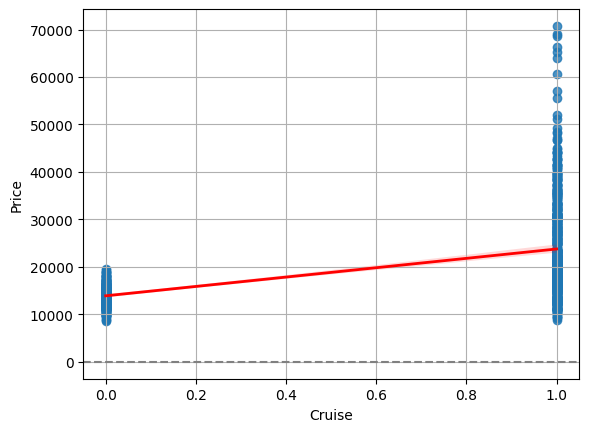

In [2343]:
draw_regplots(df, X_cols, y_col)

## Построить доверительные интервалы для коэффициентов регрессии. ##

In [2344]:
def coef_conf_intervals(results):
    confidence_intervals = results.conf_int(alpha=0.05)
    print("Доверительные интервалы:")
    print(confidence_intervals)

In [2345]:
coef_conf_intervals(results)

Доверительные интервалы:
                    0            1
const     -229.475428  5829.189134
Mileage     -0.229222    -0.099555
Cylinder  1674.435862  4341.169490
Liter    -1233.565163  2145.027273
Cruise    4747.983509  7404.114008


## В случае подозрения на наличие выбросов, проверить так называемые важные наблюдения, которые значительно влияют на построение модели. ##

In [2346]:
def outliers_tests(df, results, X_cols, y_col):
    influence = results.get_influence()

    while(True):
        dfbetas = influence.dfbetas
        dffits = influence.dffits
        cooks_distance = influence.cooks_distance
        
        n = len(results.resid)
        p = len(results.params)
        
        threshold = 4/n
        dfbetas_threshold = 2.0 * np.sqrt(n)
        dffits_threshold = 2.0 * np.sqrt(p / n)

        outliers_dfbetas = np.abs(dfbetas).max(axis=1) > dfbetas_threshold
        outliers_dffits = dffits[0] > dffits_threshold
        outliers_cook = cooks_distance[0] > threshold

        outliers_combined = outliers_dfbetas | outliers_dffits | outliers_cook
        
        if not outliers_combined.any():
            break  # Если выбросов нет, выходим из цикла

        # Удаляем выбросы из данных
        df = df[~outliers_combined]
        results = get_model(df, X_cols, y_col)  # Обновите вашу модель здесь

        # Обновляем влияние после удаления выбросов
        influence = results.get_influence()
    
    return df


In [2347]:
df = outliers_tests(df, results, X_cols, y_col)

In [2348]:
results = get_model(df, X_cols, y_col)

## Используя функцию Step или StepAIC, постараться улучшить модель. ##

In [2349]:
print("AIC:", results.aic)

AIC: 9185.160766485107


In [2350]:
def calculate_aic(model_formula, data):
    model = sm.OLS.from_formula(model_formula, data).fit()
    return model.aic, model

def step_aic(data, dependent_var, independent_vars):
    best_aic = float('inf')
    best_model = None
    best_formula = None
    
    # Генерируем все возможные комбинации предикторов
    for k in range(1, len(independent_vars) + 1):
        for subset in itertools.combinations(independent_vars, k):
            formula = f"{dependent_var} ~ {' + '.join(subset)}"
            aic, model = calculate_aic(formula, data)
            if aic < best_aic:
                best_aic = aic
                best_model = model
                best_formula = formula

    return best_formula, best_model
    
def get_best_by_aic(df, X, y):
    best_formula, best_model = step_aic(df, y, X)
    print(f"Лучшая формула: {best_formula}")
    print(f"AIC: {best_model.aic}")

In [2351]:
get_best_by_aic(df, X_cols, y_col)

Лучшая формула: Price ~ Mileage + Cylinder + Liter + Cruise
AIC: 9185.160766485107


AIC не изменился, текущая модель является наилучшей.

## Построить графики: scatterplot, "Residuals vs Fitted", "Normal Q-Q" , "Residuals vs Leverage" и дать интерпретации. ##

In [2352]:
def draw_plots(df, results):
    # 1. Scatterplot
    sns.pairplot(df)
    plt.show()

    # 2. Residuals vs Fitted
    fitted = results.fittedvalues
    residuals = results.resid

    sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
    plt.axhline(0, color='gray', linestyle='dashed')
    plt.title("Residuals vs Fitted")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.grid()
    plt.show()

    # 3. Normal Q-Q Plot
    sm.qqplot(residuals, line='45', fit=True)
    plt.title("Normal Q-Q")
    plt.grid()
    plt.show()

    # 4. Residuals vs Leverage
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_leverage_resid2(results, ax=ax)
    plt.title("Residuals vs Leverage")
    plt.grid()
    plt.show()

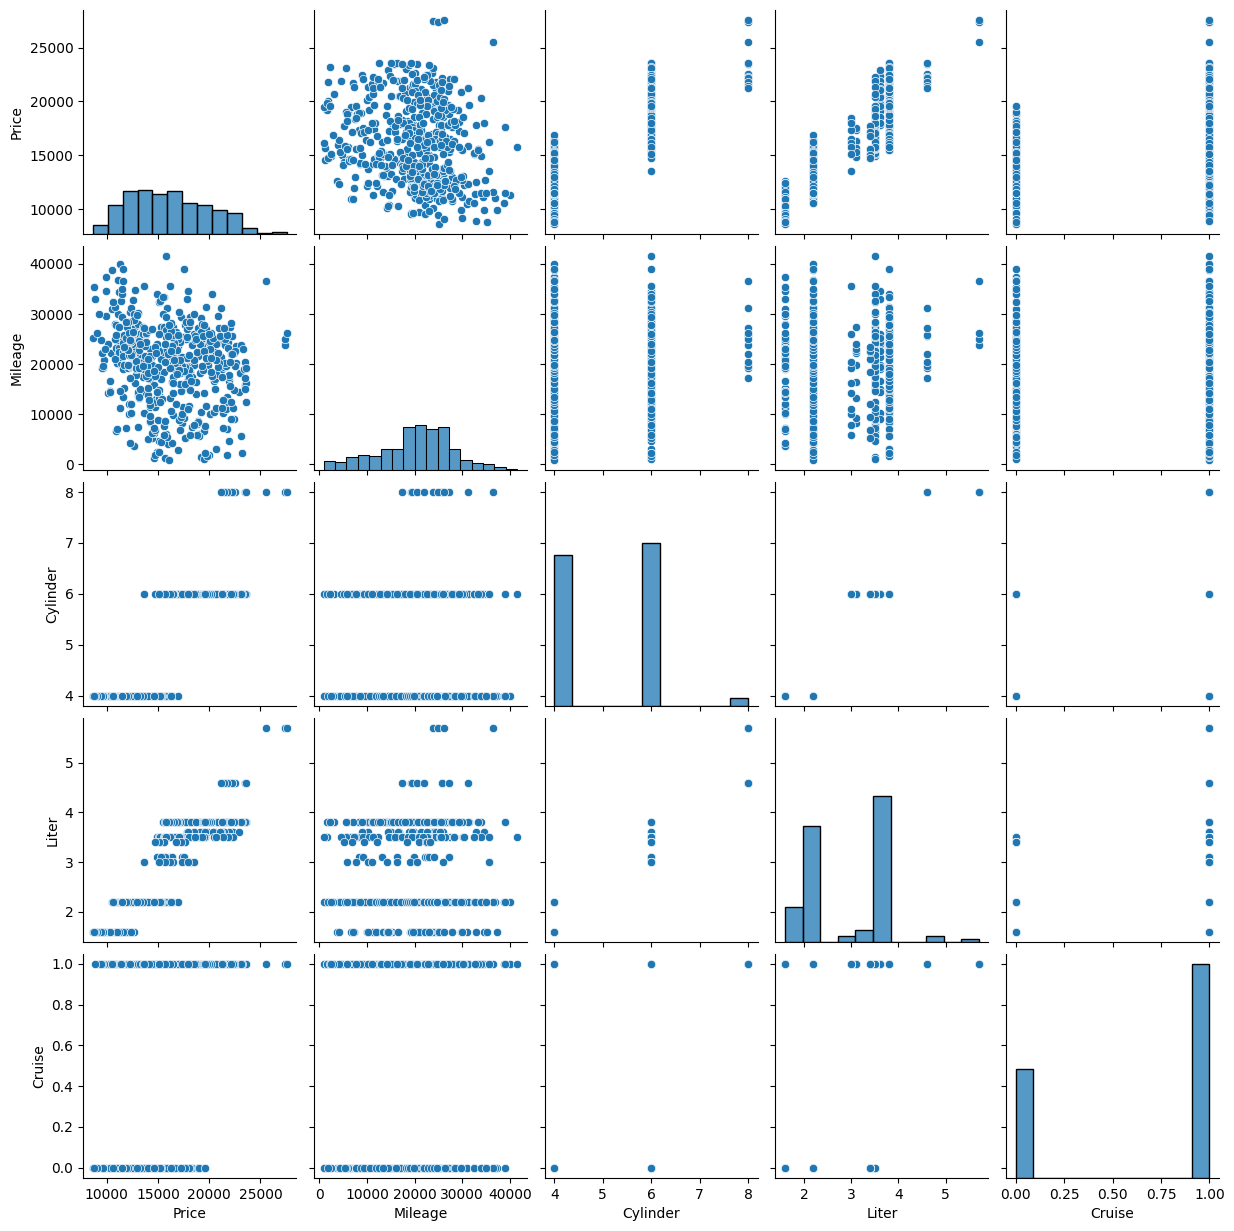

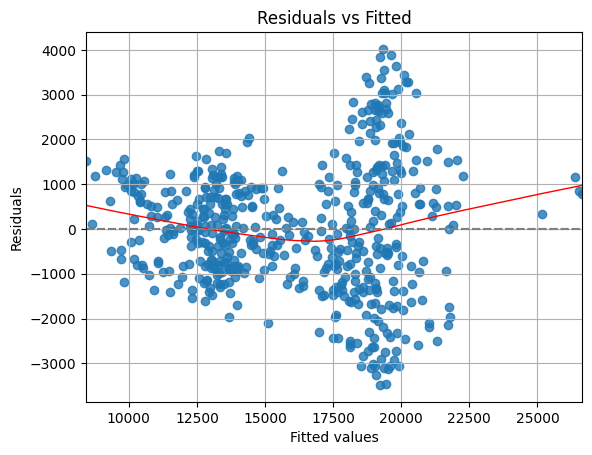

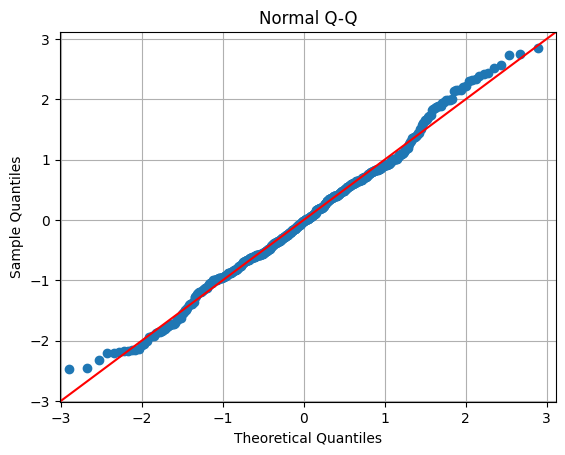

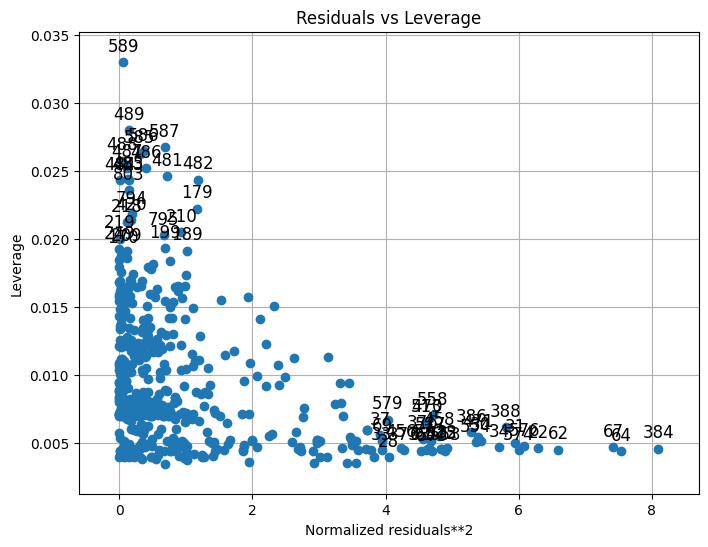

In [2353]:
draw_plots(df, results)

## Проверить модель на наличие выбросов. ##

In [2354]:
def bonf_test(results):
    # Bonferroni Outlier Test
    outlier_test = results.get_influence().summary_frame()
    bonferroni_test = results.outlier_test()

    # Просмотр результатов
    print("Bonferroni Outlier Test Results:")
    print(bonferroni_test.head())

In [2355]:
bonf_test(results)

Bonferroni Outlier Test Results:
   student_resid   unadj_p  bonf(p)
0      -0.310938  0.755972      1.0
1      -0.074342  0.940767      1.0
2      -0.680484  0.496499      1.0
3      -0.339353  0.734480      1.0
4      -0.052722  0.957973      1.0


## Проверить модель на гетероскедастичность. ##

In [2356]:
def breuschp_test(results):
    # Breusch-Pagan тест
    l_statistic, l_pvalue, f_statistic, f_pvalue = sm.stats.het_breuschpagan(results.resid, results.model.exog)
    print(f"lagrange multiplier statistic: {l_statistic}")
    print(f"p-value of lagrange multiplier test: {l_pvalue}")
    print(f"f-statistic of the hypothesis that the error variance does not depend on x: {f_statistic}")
    print(f"f_pvalue: {f_pvalue}")
    if (l_pvalue < 0.05 and f_pvalue < 0.05):
        print ("Для обеих статистик pvalue < 0.05. Дисперсии остатков одинаковы (гомоскедастичность)")
    elif (l_pvalue > 0.05 and f_pvalue > 0.05):
        print("Для обеих статистик pvalue > 0.05. Дисперсии остатков не одинаковы (гетероскедастичность)")
    else:
        print("Для одной статистики pvalue > 0.05, для другой pvalue < 0.05")

In [2357]:
breuschp_test(results)

lagrange multiplier statistic: 104.63913015012291
p-value of lagrange multiplier test: 1.0110862178845824e-21
f-statistic of the hypothesis that the error variance does not depend on x: 32.30205003235896
f_pvalue: 4.406670343546596e-24
Для обеих статистик pvalue < 0.05. Дисперсии остатков одинаковы (гомоскедастичность)


## Проверить остатки модели на автокорреляцию. ##

In [2358]:
def autocorr_test(results):
    dw_statistic = sm.stats.durbin_watson(results.resid)
    print("Durbin-Watson Test")
    print(f"Durbin-Watson Statistic: {dw_statistic}")

In [2359]:
autocorr_test(results)

Durbin-Watson Test
Durbin-Watson Statistic: 0.3707035423898925


Статистика принимает знчения от 0 до 4. Статистика равная 2 означает, что автокорреляция отсутствует. Статистика близка к 0 - **остатки не являются независимыми**.

## Проверить остатки  модели на нормальность распределения. ##

In [2360]:
def norm_tests(results):
    ks_stat, ks_p_value = stats.kstest(results.resid, 'norm')
    sw_stat, sw_p_value = stats.shapiro(results.resid)
    if ks_p_value < 0.05:
        ks_res = "pvalue < 0.05 (остатки не подвержены нормальному распределению)"
    else:
        ks_res = "pvalue > 0.05 (остатки подвержены нормальному распределению)"
        
    if sw_p_value < 0.05:
        sw_res = "pvalue < 0.05 (остатки не подвержены нормальному распределению)"
    else:
        sw_res = "pvalue > 0.05 (остатки подвержены нормальному распределению)"

    print(f"Kolmogorov-Smirnov Test Statistic: {ks_stat}")
    print(f"p-value: {ks_p_value}")
    print(ks_res)
    print(f"Shapiro-Wilk Test Statistic: {sw_stat}")
    print(f"p-value: {sw_p_value}")
    print(sw_res)

In [2361]:
norm_tests(results)

Kolmogorov-Smirnov Test Statistic: 0.504725897920605
p-value: 2.6191577630451374e-125
pvalue < 0.05 (остатки не подвержены нормальному распределению)
Shapiro-Wilk Test Statistic: 0.9928482964115305
p-value: 0.01260728033391666
pvalue < 0.05 (остатки не подвержены нормальному распределению)


## Проверить модель на мультиколлинеарность данных. ##

In [2362]:
def multicol(X):
    vif = pd.DataFrame()
    vif['variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif)

In [2363]:
multicol(df[X_cols])

   variable         VIF
0   Mileage    6.578033
1  Cylinder  111.811338
2     Liter   99.408250
3    Cruise    3.776302


VIF для **Cylinder** и **Liter** значительно > 10, следовательно, эти **переменные сильно зависят** от линейной комбинации других переменных. **Mileage** > 5, имеется **умеренная мультиколлинеарность**.

## Попробовать применить трансформацию Box-Cox зависимой переменной. ##

In [2364]:
def box_cox(df, y):
    # Применение трансформации Box-Cox к зависимой переменной
    df_copy = df
    y_transformed, lambda_ = stats.boxcox(df_copy[y] + 1)  # Добавляем единицу для предотвращения отрицательных значений
    # Обновляем DataFrame с трансформированной переменной
    df_copy[y] = y_transformed
    print(f"lambda: {lambda_}")
    return df_copy

In [2365]:
df = box_cox(df,y_col)

lambda: 0.20038611918026525


## В случае получения новой модели в предыдущем пункте проанализировать новую модель. ##

In [2366]:
results = get_model(df, X_cols, y_col)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     950.3
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          1.57e-238
Time:                        05:08:21   Log-Likelihood:                -452.31
No. Observations:                 529   AIC:                             914.6
Df Residuals:                     524   BIC:                             936.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3818      0.168    156.921      0.0

# Dataset “sleep”

In [2367]:
df = pd.read_csv("/kaggle/input/sleep-dataset/dataset_2191_sleep.csv")

In [2368]:
df

,body_weight,brain_weight,max_life_span,gestation_time,predation_index,sleep_exposure_index,danger_index,total_sleep
0,6654.000,5712.0,38.6,645,3,5,3,3.3
1,1.000,6.6,4.5,42,3,1,3,8.3
2,3.385,44.5,14,60,1,1,1,12.5
3,0.920,5.7,?,25,5,2,3,16.5
4,2547.000,4603.0,69,624,3,5,4,3.9
...,...,...,...,...,...,...,...,...
57,2.000,12.3,7.5,200,3,1,3,5.4
58,0.104,2.5,2.3,46,3,2,2,15.8
59,4.190,58.0,24,210,4,3,4,10.3
60,3.500,3.9,3,14,2,1,1,19.4


## Построить базовую модель линейной регрессии.

In [2369]:
X_cols = ["body_weight", "brain_weight", "max_life_span", "gestation_time", "predation_index", "sleep_exposure_index", "danger_index"]
y_col = "total_sleep"

Заменяю неизвестные величины на их среднее, а также преобразую типы

In [2370]:
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')
df.fillna(df.mean(), inplace=True)

In [2371]:
results = get_model(df, X_cols, y_col)

## Вывести результаты анализа базовой модели. ##

In [2372]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sleep   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     7.991
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           1.24e-06
Time:                        05:08:21   Log-Likelihood:                -158.03
No. Observations:                  62   AIC:                             332.1
Df Residuals:                      54   BIC:                             349.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   15.9593 

## Записать уравнение линейной регрессии. ##

In [2373]:
print_equation(results)

Уравнение линейной регрессии:
y = 15.959 + (-0.002) * x1 + (0.002) * x2 + (-0.069) * x3 + (-0.009) * x4 + (1.246) * x5 + (0.288) * x6 + (-2.774) * x7


## Проверить значимость каждого отдельного коэффициента с помощью  T-test. ##

In [2374]:
t_test(results)

Intercept: t_statistic = 13.852, pvalue = 0.000 (коэффициент значим)
x1: t_statistic = -1.092, pvalue = 0.280 (коэффициент не значим)
x2: t_statistic = 1.096, pvalue = 0.278 (коэффициент не значим)
x3: t_statistic = -1.793, pvalue = 0.079 (коэффициент не значим)
x4: t_statistic = -1.557, pvalue = 0.125 (коэффициент не значим)
x5: t_statistic = 1.514, pvalue = 0.136 (коэффициент не значим)
x6: t_statistic = 0.501, pvalue = 0.619 (коэффициент не значим)
x7: t_statistic = -2.617, pvalue = 0.011 (коэффициент значим)


## Проверить значимость построенного уравнения регрессии с помощью F-test. ##

In [2375]:
f_test(results)

F-statistic: 7.9914, p-value: 0.0000
pvalue < 0.05. (модель значима)


## Построить график рассеяния и уравнения регрессии. ##

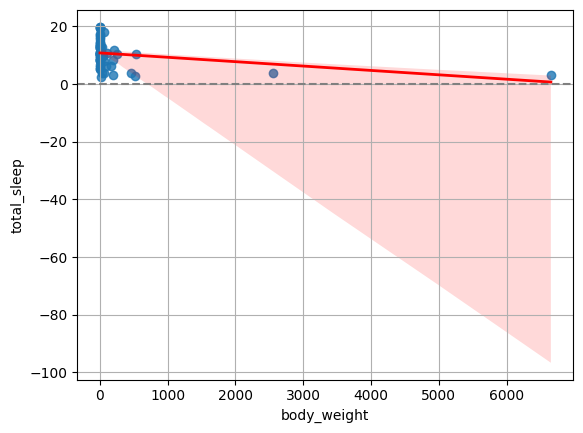

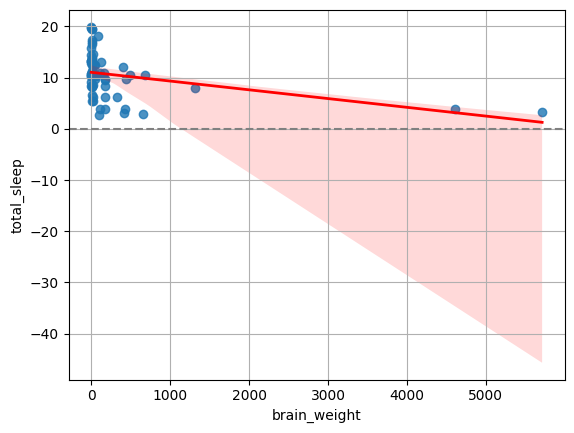

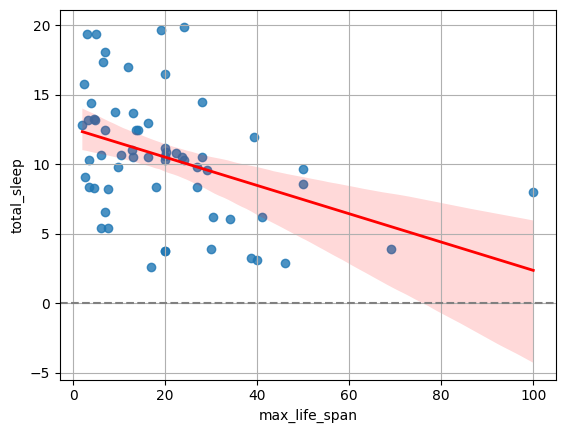

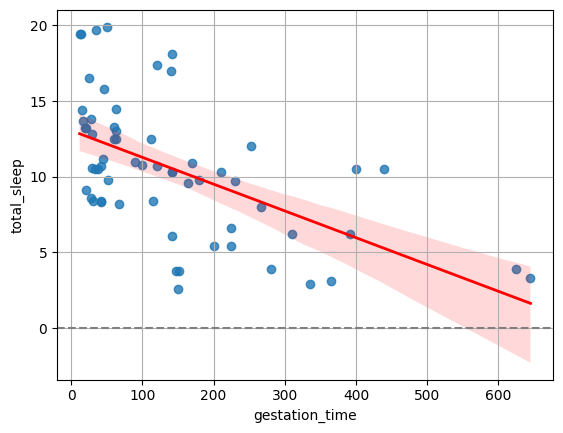

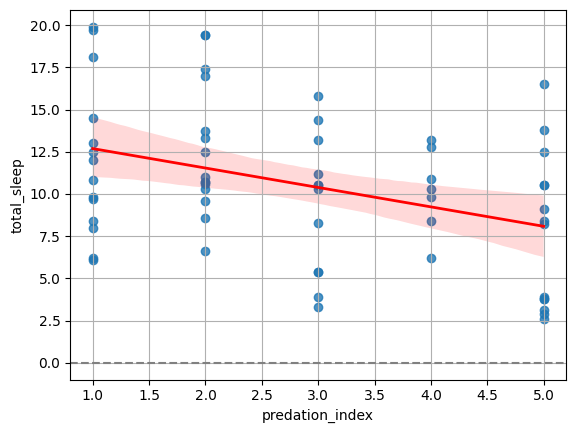

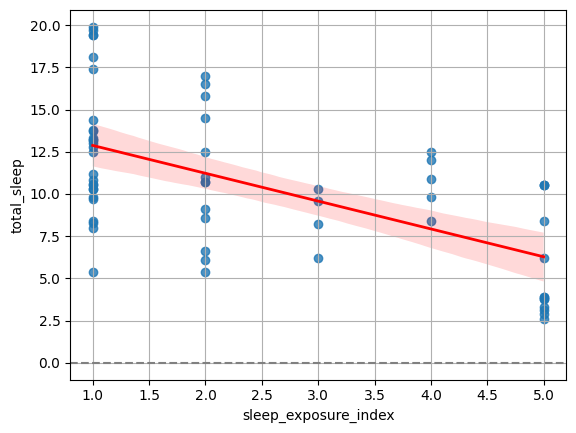

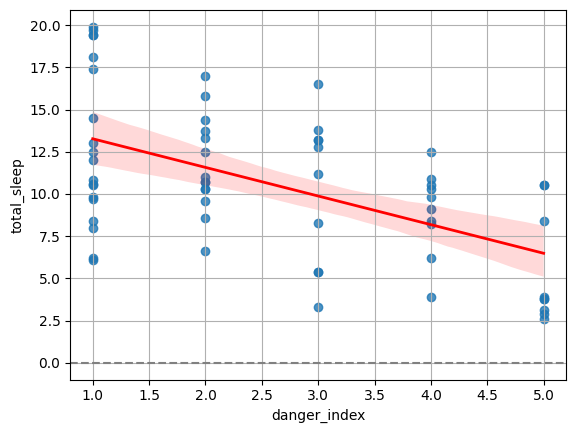

In [2376]:
draw_regplots(df, X_cols, y_col)

## Построить доверительные интервалы для коэффициентов регрессии. ##

In [2377]:
coef_conf_intervals(results)

Доверительные интервалы:
                              0          1
const                 13.649297  18.269212
body_weight           -0.005151   0.001518
brain_weight          -0.001656   0.005651
max_life_span         -0.146092   0.008167
gestation_time        -0.020656   0.002596
predation_index       -0.404424   2.896581
sleep_exposure_index  -0.865577   1.441881
danger_index          -4.899645  -0.649122


## В случае подозрения на наличие выбросов, проверить так называемые важные наблюдения, которые значительно влияют на построение модели. ##

In [2378]:
df = outliers_tests(df, results, X_cols, y_col)

In [2379]:
results = get_model(df, X_cols, y_col)

## Используя функцию Step или StepAIC, постараться улучшить модель. ##

In [2380]:
print("AIC:", results.aic)

AIC: 243.3484050783161


In [2381]:
get_best_by_aic(df, X_cols, y_col)

Лучшая формула: total_sleep ~ body_weight + brain_weight + max_life_span + gestation_time + predation_index + danger_index
AIC: 243.23773894680437


AIC стал меньше. Применяем новую модель.

In [2382]:
X_cols = ["brain_weight", "max_life_span", "gestation_time", "predation_index", "danger_index"]
results = get_model(df, X_cols, y_col)

## В случае получения в предыдущем пункте модели, отличной от базовой, повторить пп. c-i для новой модели. ##

In [2383]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sleep   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     22.98
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           2.22e-11
Time:                        05:08:25   Log-Likelihood:                -115.92
No. Observations:                  51   AIC:                             243.8
Df Residuals:                      45   BIC:                             255.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              14.8532      1.086     

In [2384]:
print_equation(results)

Уравнение линейной регрессии:
y = 14.853 + (-0.011) * x1 + (0.161) * x2 + (-0.017) * x3 + (2.437) * x4 + (-4.061) * x5


In [2385]:
t_test(results)

Intercept: t_statistic = 13.671, pvalue = 0.000 (коэффициент значим)
x1: t_statistic = -2.060, pvalue = 0.045 (коэффициент значим)
x2: t_statistic = 2.782, pvalue = 0.008 (коэффициент значим)
x3: t_statistic = -2.986, pvalue = 0.005 (коэффициент значим)
x4: t_statistic = 3.533, pvalue = 0.001 (коэффициент значим)
x5: t_statistic = -5.384, pvalue = 0.000 (коэффициент значим)


In [2386]:
f_test(results)

F-statistic: 22.9782, p-value: 0.0000
pvalue < 0.05. (модель значима)


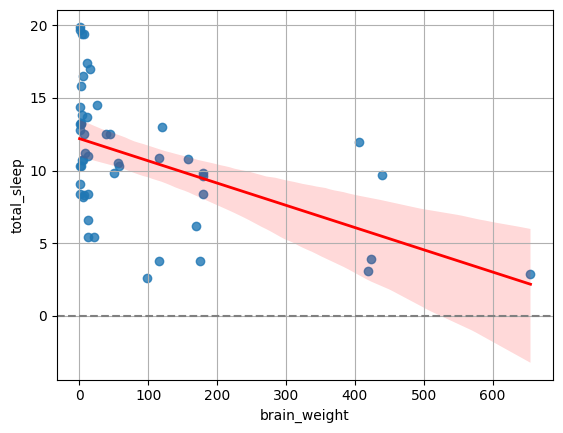

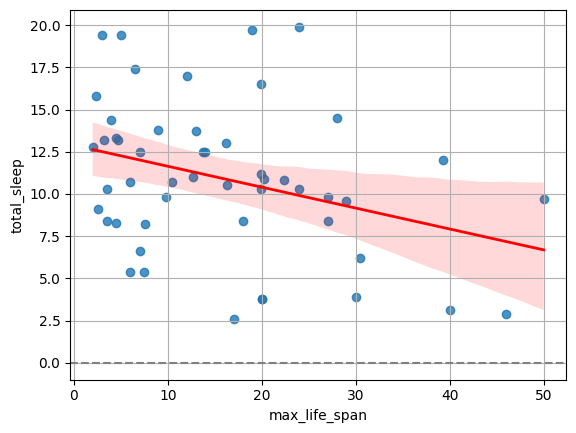

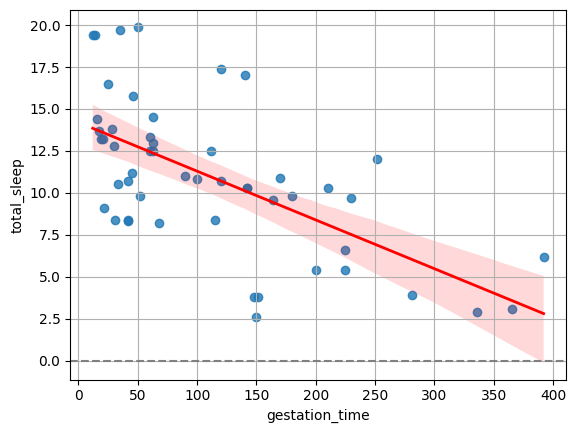

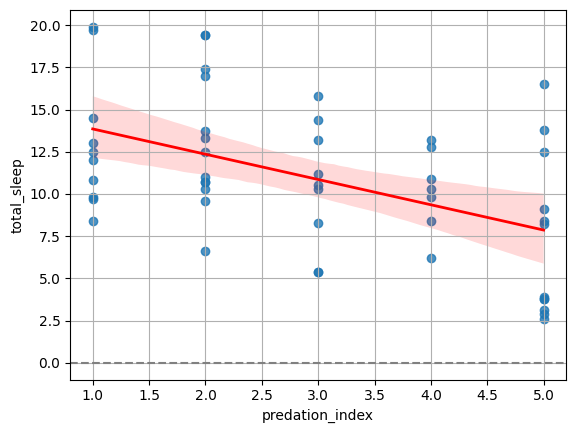

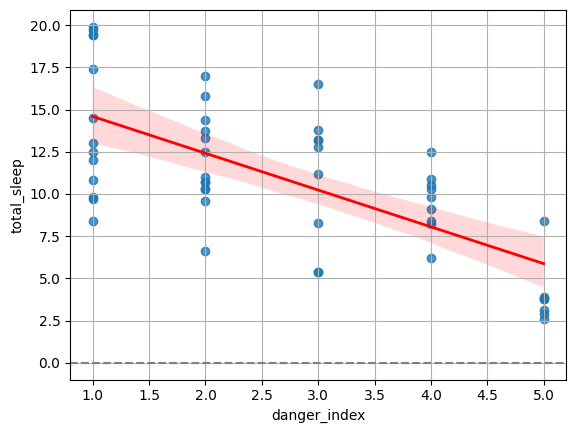

In [2387]:
draw_regplots(df, X_cols, y_col)

In [2388]:
coef_conf_intervals(results)

Доверительные интервалы:
                         0          1
const            12.664980  17.041462
brain_weight     -0.020818  -0.000237
max_life_span     0.044431   0.277439
gestation_time   -0.028329  -0.005505
predation_index   1.047520   3.825911
danger_index     -5.580822  -2.542096


In [2389]:
df = outliers_tests(df, results, X_cols, y_col)

In [2390]:
results = get_model(df, X_cols, y_col)

In [2391]:
print("AIC:", results.aic)

AIC: 134.49947068873834


## Построить графики: scatterplot, "Residuals vs Fitted", "Normal Q-Q" , "Residuals vs Leverage" и дать интерпретации. ##

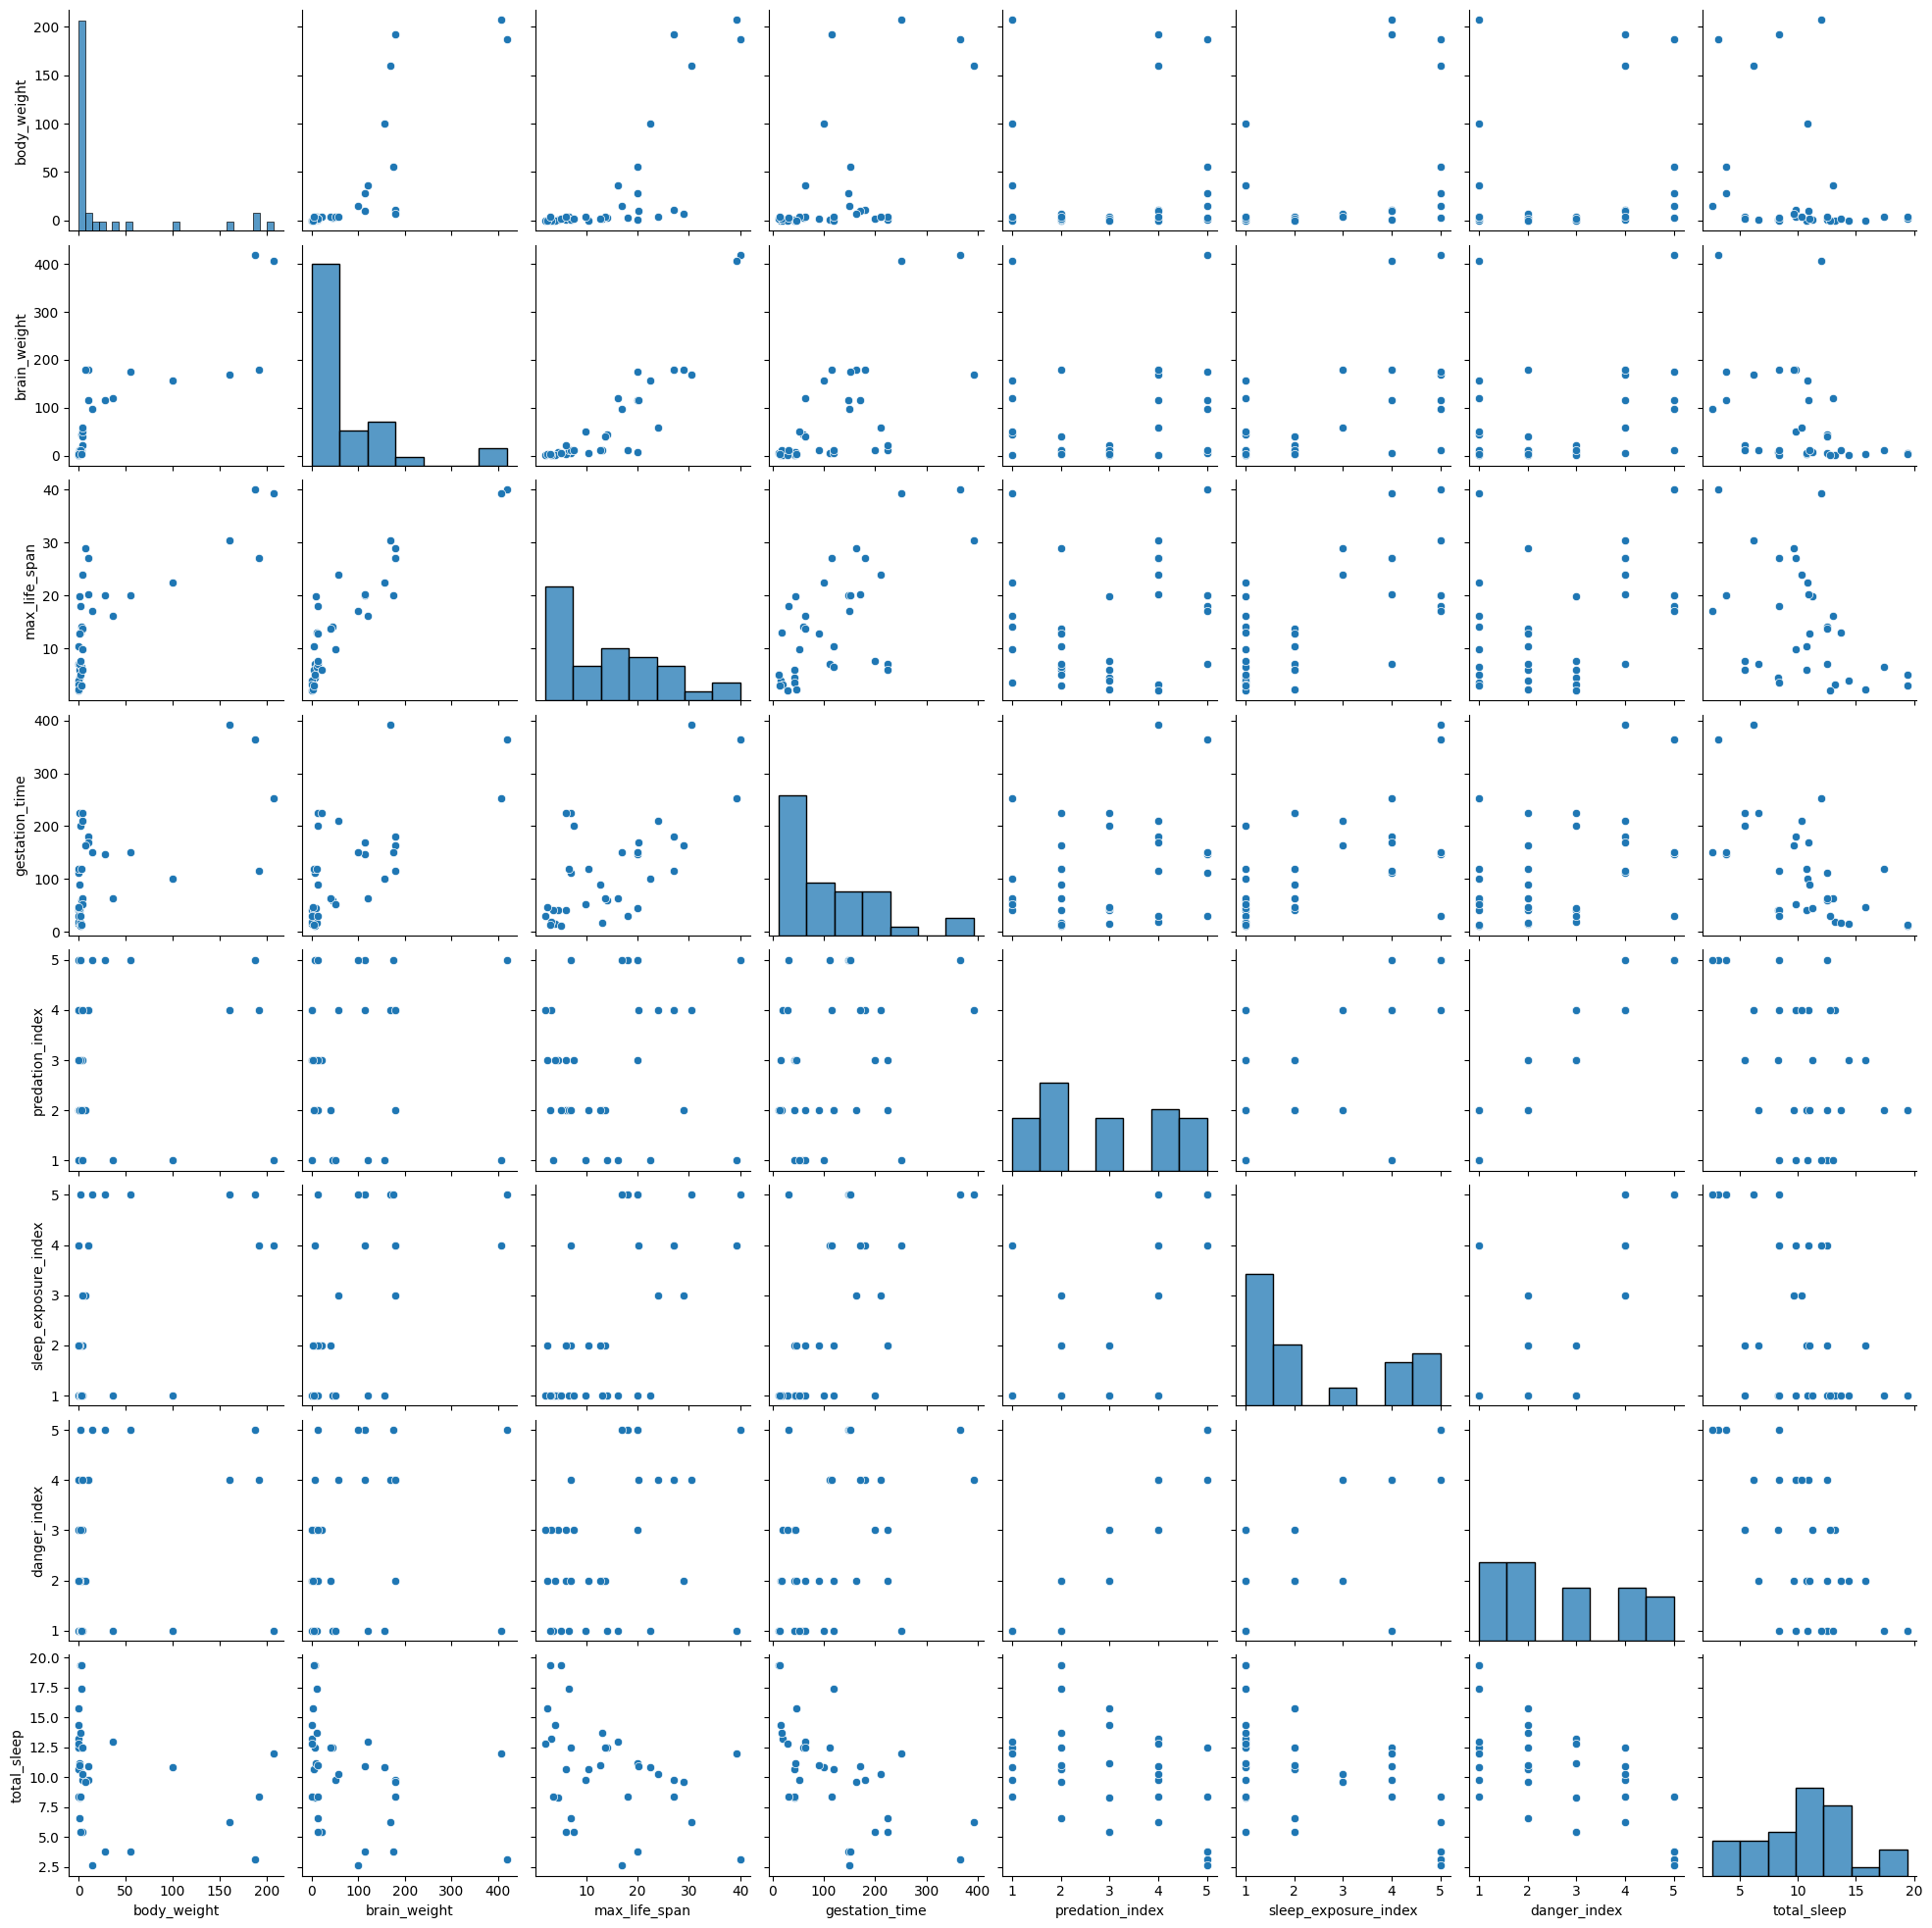

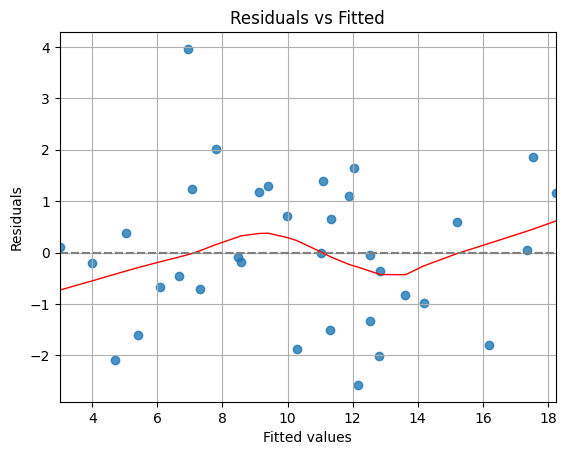

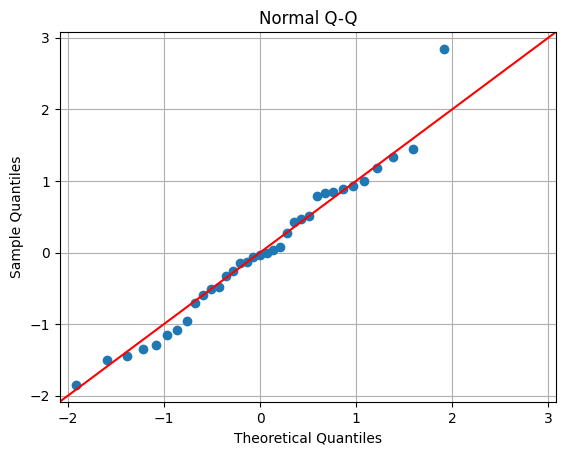

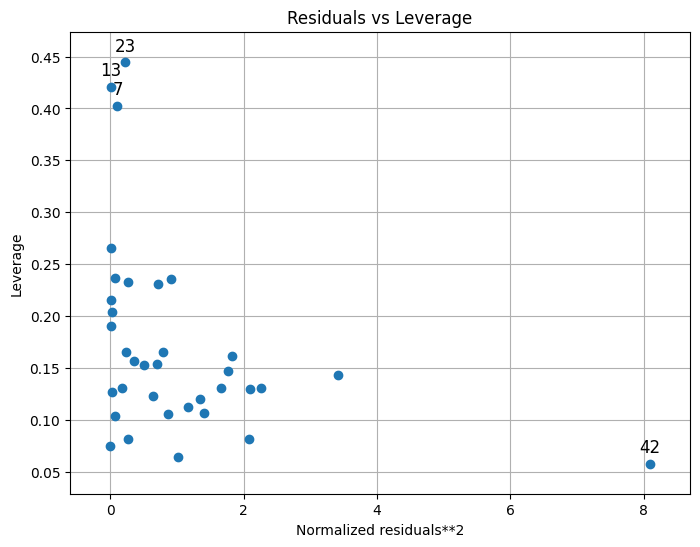

In [2392]:
draw_plots(df, results)

## Проверить модель на наличие выбросов. ##

In [2393]:
bonf_test(results)

Bonferroni Outlier Test Results:
    student_resid   unadj_p  bonf(p)
1        0.880821  0.385913      1.0
2       -0.238750  0.813038      1.0
5        1.390804  0.175240      1.0
7       -0.375072  0.710433      1.0
10      -0.034442  0.972769      1.0


Нулевая гипотеза - отсутствие сдвигов

## Проверить модель на гетероскедастичность. ##

In [2394]:
breuschp_test(results)

lagrange multiplier statistic: 1.5866160816667856
p-value of lagrange multiplier test: 0.902863100918132
f-statistic of the hypothesis that the error variance does not depend on x: 0.27540979674968524
f_pvalue: 0.9228484074012762
Для обеих статистик pvalue > 0.05. Дисперсии остатков не одинаковы (гетероскедастичность)


## Проверить остатки модели на автокорреляцию. ##

In [2395]:
autocorr_test(results)

Durbin-Watson Test
Durbin-Watson Statistic: 1.6012922328584633


Значение статистики близко к 2. Можно предположить, что остатки не сильно коррелируют.

## Проверить остатки  модели на нормальность распределения. ##

In [2396]:
norm_tests(results)

Kolmogorov-Smirnov Test Statistic: 0.15135652729717175
p-value: 0.36232019515471237
pvalue > 0.05 (остатки подвержены нормальному распределению)
Shapiro-Wilk Test Statistic: 0.9746654115758381
p-value: 0.5832024947879613
pvalue > 0.05 (остатки подвержены нормальному распределению)


## Проверить модель на мультиколлинеарность данных. ##

In [2397]:
multicol(df[X_cols])

          variable        VIF
0     brain_weight   7.008593
1    max_life_span  13.643830
2   gestation_time   5.197004
3  predation_index  56.783098
4     danger_index  69.124533


threshold = 10

## Попробовать применить трансформацию Box-Cox зависимой переменной. ##

In [2398]:
df = box_cox(df, y_col)

lambda: 0.8236720326579096


## В случае получения новой модели в предыдущем пункте проанализировать новую модель. ##

In [2399]:
results = get_model(df, X_cols, y_col)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_sleep   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     45.08
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           8.39e-13
Time:                        05:08:48   Log-Likelihood:                -46.922
No. Observations:                  35   AIC:                             105.8
Df Residuals:                      29   BIC:                             115.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.3384      0.557     